
# Linear vs Polynomial Regression on Wine Quality Dataset

**Goals**
- Use the open-source [Wine Quality dataset (red wine)](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- Enforce a **70/15/15** train/validation/test split with no leakage
- Use **Mean Squared Error (MSE)** for evaluations
- Compare **Linear Regression** closed loop vs gradient decent
- Compare **Linear Regression** (degree=1) vs **Polynomial Regression** (higher degrees)




In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_openml

np.random.seed(42)


## 1) Load wine quality dataset and make a 70/15/15 split

In [2]:
import pandas as pd

# Load Wine Quality (red) dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")



In [3]:
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:

X_all = df[["citric acid"]].values
y_all = df["pH"].values
# Step 1: Train vs Holdout (70/30)
X_train, X_hold, y_train, y_hold = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Step 2: Split holdout (30%) into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_hold, y_hold, test_size=0.5, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1119, 1) (1119,)
Validation: (240, 1) (240,)
Test: (240, 1) (240,)


In [6]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(random_state=42, max_iter=1000)
sgd.fit(X_train, y_train)

print("Coefficients:", sgd.coef_)
print("Intercept:", sgd.intercept_)


Coefficients: [0.23507704]
Intercept: [3.24519171]


In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

Coefficients: [-0.42000125]
Intercept: 3.427777103325644


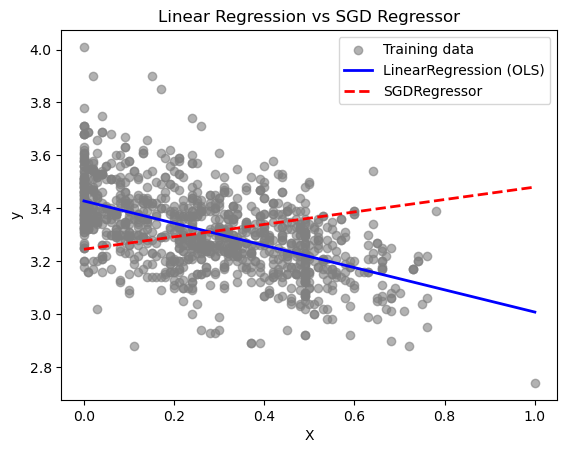

In [8]:
# Create line space for predictions
x_range = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)

y_sgd = sgd.predict(x_range)
y_lr = lr.predict(x_range)
# Plot data and lines
plt.scatter(X_train, y_train, color="gray", alpha=0.6, label="Training data")
plt.plot(x_range, y_lr, color="blue", linewidth=2, label="LinearRegression (OLS)")
plt.plot(x_range, y_sgd, color="red", linestyle="--", linewidth=2, label="SGDRegressor")

plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear Regression vs SGD Regressor")
plt.legend()
plt.show()

## 2) Fit polynomial models on the train set and evaluate MSE on train & validation

In [9]:
# Define the polynomial degrees we want to test
degrees = [1, 2, 3, 5, 7, 9, 11, 15]

# Store results in the format: (degree, train_MSE, val_MSE)
results = []

# Loop through each polynomial degree
for d in degrees:
    # Build a pipeline:
    # 1. StandardScaler -> normalize features
    # 2. PolynomialFeatures -> create polynomial terms up to degree d
    # 3. LinearRegression -> fit linear model on transformed features
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=d)),
        ('regressor', LinearRegression())
    ])
    
    # Train the model on the training data
    pipe.fit(X_train, y_train)
    
    # Evaluate model performance on train set (to detect overfitting)
    mse_tr = mean_squared_error(y_train, pipe.predict(X_train))
    
    # Evaluate model performance on validation set (for model selection)
    mse_va = mean_squared_error(y_val, pipe.predict(X_val))
    
    # Save results for this degree
    results.append((d, mse_tr, mse_va))

# Convert results into a numpy array for easy analysis
results_array = np.array(results, dtype=float)

# Find the index of the model with the lowest validation MSE
best_idx = np.argmin(results_array[:, 2])

# Extract the best degree (with lowest validation MSE)
best_degree = int(results_array[best_idx, 0])

# Show the best degree and the full table of results
best_degree, results_array


(9,
 array([[ 1.        ,  0.01695315,  0.017971  ],
        [ 2.        ,  0.01693594,  0.01787198],
        [ 3.        ,  0.01674377,  0.01761658],
        [ 5.        ,  0.01670402,  0.0175914 ],
        [ 7.        ,  0.01667905,  0.01762685],
        [ 9.        ,  0.01662172,  0.01751873],
        [11.        ,  0.01652318,  0.01759776],
        [15.        ,  0.01644746,  0.01768893]]))

## 3) Model selection by validation MSE and visualization

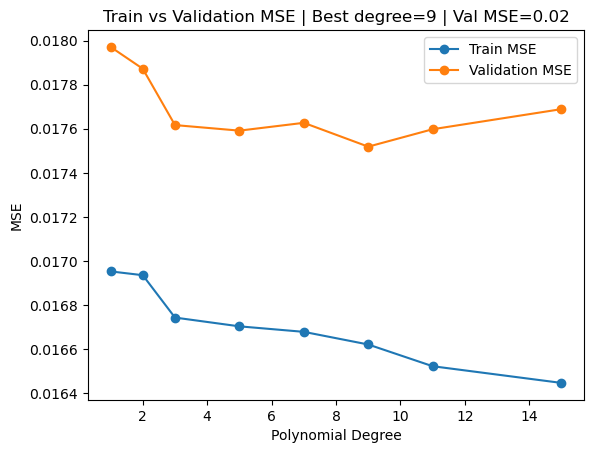

In [10]:
# Extract polynomial degrees from the first column of results_array
deg = results_array[:,0]

# Extract training MSE values from the second column
mse_tr = results_array[:,1]

# Extract validation MSE values from the third column
mse_va = results_array[:,2]

plt.figure()

# Plot training MSE vs polynomial degree
plt.plot(deg, mse_tr, marker="o", label="Train MSE")

# Plot validation MSE vs polynomial degree
plt.plot(deg, mse_va, marker="o", label="Validation MSE")

plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title(f"Train vs Validation MSE | Best degree={best_degree} | Val MSE={mse_va[best_idx]:.2f}")
plt.legend()
plt.show()



## 4) Evaluate on test

In [11]:
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('regressor', LinearRegression())
])
final_model.fit(X_train, y_train)
mse_test = mean_squared_error(y_test, final_model.predict(X_test))
mse_test


0.015223546760392523

## 5) My first neural network

In [15]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))

# 1) To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# 2) Simple 3-layer NN
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = SimpleNN()

# 3) Loss/optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4) Train
model.train()
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train MSE (scaled): {loss.item():.4f}")

# 5) Eval
model.eval()
with torch.no_grad():
    y_pred = model(X_val)
    val_mse = criterion(y_pred, y_val).item()

# Back to original pH units
y_pred_orig = scaler_y.inverse_transform(y_pred.numpy())
y_true_orig = scaler_y.inverse_transform(y_val.numpy())

# Print a few samples
for i in range(5):
    print(f"True pH: {y_true_orig[i,0]:.2f} | Pred pH: {y_pred_orig[i,0]:.2f}")
    
#Validation Loss
print(val_mse)

Epoch 50/500 | Train MSE (scaled): 0.7270
Epoch 100/500 | Train MSE (scaled): 0.7155
Epoch 150/500 | Train MSE (scaled): 0.7120
Epoch 200/500 | Train MSE (scaled): 0.7078
Epoch 250/500 | Train MSE (scaled): 0.7055
Epoch 300/500 | Train MSE (scaled): 0.7049
Epoch 350/500 | Train MSE (scaled): 0.7045
Epoch 400/500 | Train MSE (scaled): 0.7043
Epoch 450/500 | Train MSE (scaled): 0.7039
Epoch 500/500 | Train MSE (scaled): 0.7036
True pH: 3.21 | Pred pH: 3.30
True pH: 3.40 | Pred pH: 3.30
True pH: 3.35 | Pred pH: 3.39
True pH: 3.28 | Pred pH: 3.31
True pH: 3.72 | Pred pH: 3.42
0.7395660281181335
